In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import sys
import logging

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions


import pandas as pd
import numpy as np

from linux_qm.src.render import indigo, draw_reacting_mapnums
from linux_qm.src.util import load_smiles3D
from linux_qm.qm.orca.orca import OrcaDriver

In [3]:
df = pd.read_csv('../data/slv_amides/amide_training_set.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15999 entries, 0 to 15998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rxn_id            15999 non-null  int64  
 1   acid_smi          15999 non-null  object 
 2   amine_smi         15999 non-null  object 
 3   product_smi       15999 non-null  object 
 4   activators_names  9719 non-null   object 
 5   yield             15999 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 750.1+ KB


In [4]:
df['rxn_smi'] = df.amine_smi + '.' + df.acid_smi + '>>' + df.product_smi
df.rxn_smi

0        N[C@@H](CCCCNC(=O)C(F)(F)F)C(=O)O.OC(CCCCCCCCC...
1        NCC(=O)NCC(=O)NCC(=O)O.OC(CSC(C)=O)=O>>[CH3:1]...
2        NCCN.OC(=O)CCN(CCNC(=O)CCN(CCOCCOCCOCC1OCCO1)C...
3        NCCN.OC(CC(OC)OC)=O>>[CH3:1][O:2][CH:3]([O:19]...
4        NCc1cccc(CN)c1.OC(CC(OC)OC)=O>>[CH3:1][O:2][CH...
                               ...                        
15994    CCO[Si](CCCN)(OCC)OCC.OC(=O)CC=O>>[CH3:1][CH2:...
15995    NCCC(=O)O.OC(C(=C)C)=O>>[CH2:1]=[C:2]([C:4]([N...
15996    N1CCOCC1.OC(c1cc(NC(CC(C)(C)C)(C)C)[n]c(Cl)[n]...
15997    CC[C@H](C)N.OC(=O)c1cc(Cl)cc(F)[n]1>>[CH3:1][C...
15998    NCc1ccccc1.OC(=O)c1[n]cc[n][n]1>>[O:1]=[C:2]([...
Name: rxn_smi, Length: 15999, dtype: object

[NH2:1][c:2]1[cH:8]cc(O)[cH:4][cH:3]1.[CH3:9][C:10](=O)[OH:11]>>CC(=O)[NH:1][c:2]1[cH:3][cH:4][c:10]([OH:11])[cH:9][cH:8]1
Reacting Atom Idx: ((0, 2, 3, 4, 5, 6), (0, 1, 2))
Mapped reacting atom: N 1
Mapped reacting atom: C 8
Mapped reacting atom: C 0
Mapped reacting atom: C 0
Mapped reacting atom: O 0
Mapped reacting atom: C 4
Mapped reacting atom: C 9
Mapped reacting atom: C 10
Mapped reacting atom: O 0


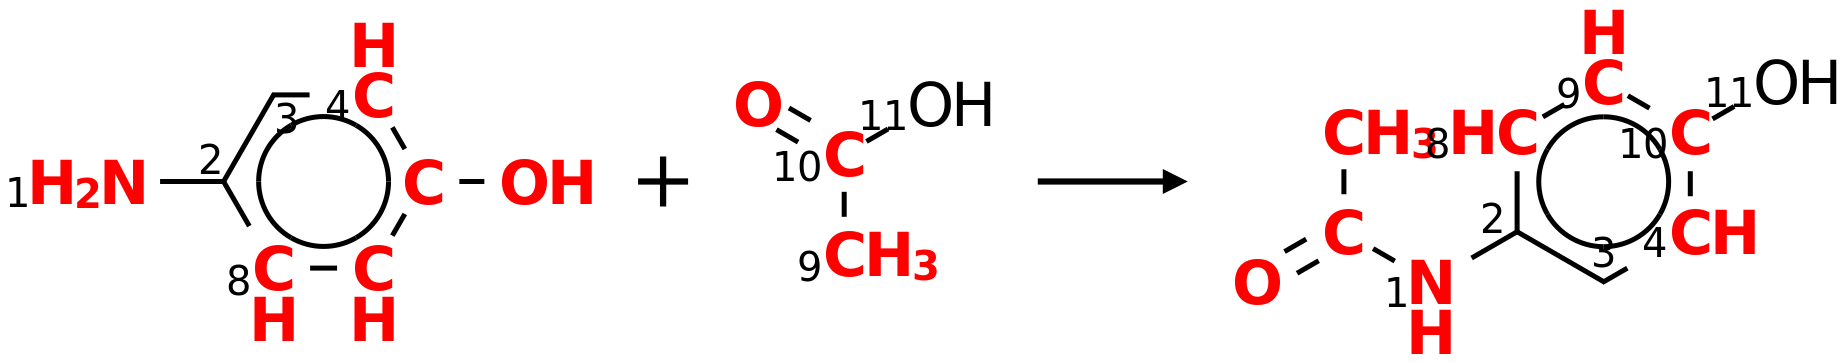

[1, 8, 0, 0, 0, 4, 9, 10, 0]

In [5]:
# rxn_smi = df.rxn_smi.sample(1).iat[0]
rxn_smi = "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc2ccc(O)cc2)=O"

ind_rxn = indigo.loadReaction(rxn_smi)
ind_rxn.automap("discard")
rxn_smi = ind_rxn.smiles()

print(rxn_smi)

draw_reacting_mapnums(rxn_smi)

In [6]:
import re

re.sub(r':\d+','',  rxn_smi)

'[NH2][c]1[cH]cc(O)[cH][cH]1.[CH3][C](=O)[OH]>>CC(=O)[NH][c]1[cH][cH][c]([OH])[cH][cH]1'

In [7]:
from rxnmapper import BatchedMapper
rxn_mapper = BatchedMapper(batch_size=16)

def rxn_map(rxn_smi):
    clear_smi = re.sub(r':\d+','',  rxn_smi)
    mapped_rxn = list(rxn_mapper.map_reactions([clear_smi]))[0]
    return mapped_rxn

Reacting Atom Idx: ((0,), (1, 3))
Mapped reacting atom: N 4
Mapped reacting atom: C 2
Mapped reacting atom: O 0


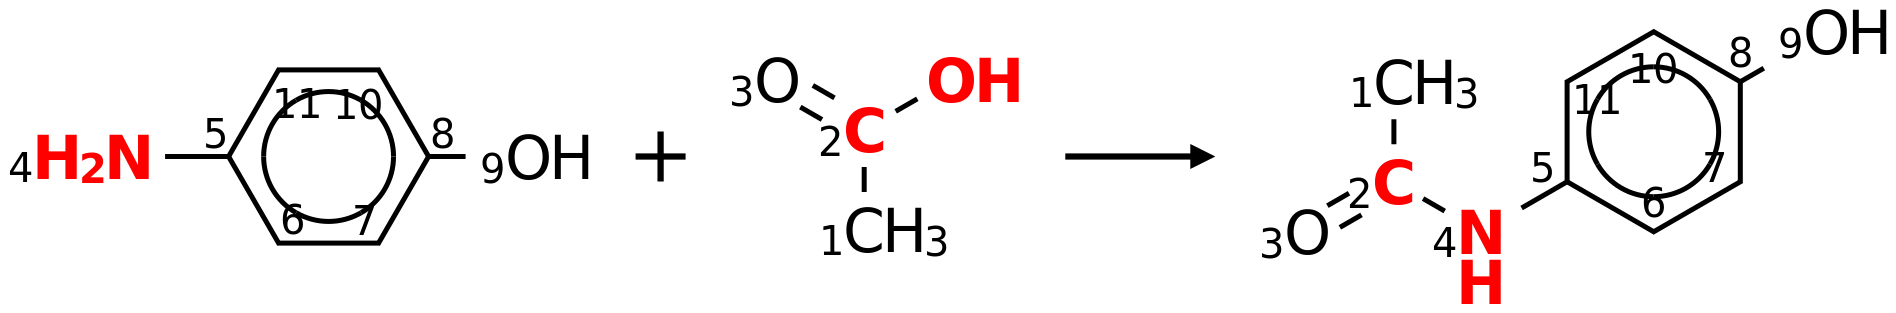

[4, 2, 0]

In [8]:
draw_reacting_mapnums(rxn_map(rxn_smi))

In [31]:
def automap_rxn(rxn_smi):
    ind_rxn = indigo.loadReaction(rxn_smi)
    ind_rxn.automap("discard")
    return ind_rxn.smiles()


def get_amine_atoms(mol, reacting_nitrogen_idx: int):
    amine_aids = [reacting_nitrogen_idx]
    atom = mol.GetAtomWithIdx(reacting_nitrogen_idx)
    for a in atom.GetNeighbors():
        if a.GetSymbol() == 'C':
            amine_aids.append(a.GetIdx())
    return amine_aids


def orca_calculation(conf):
    orca = OrcaDriver()

    orca.options['n_jobs'] = 1

    orca.options['method'] = 'XTB2'
    orca.geometry_optimization(conf)

    orca.options['method'] = 'HF-3c'
    # orca.options['method'] = 'BP86 def2-SVP def2/J D3BJ RIJCOSX'
    data = orca.single_point(conf, calc_npa=False)

    # data = orca.geometry_optimization(conf, calc_npa=True)
    return data

def gen_amine_electronic(rxn_smi):
    # rxn_smi = automap_rxn(rxn_smi)
    rxn_smi = rxn_map(rxn_smi)

    # load rxn
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()

    # get amine mol
    amine, _ = rxn.GetReactants()
    mol = load_smiles3D(Chem.MolToSmiles(amine), opt=True)

    # qm calculation
    data = orca_calculation(mol.GetConformer())

    # parse output
    amine_raids = get_amine_atoms(amine, rxn.GetReactingAtoms()[0][0])
    for i in amine_raids:
        logging.debug(amine.GetAtomWithIdx(i).GetSymbol())

    charges = np.hstack([
        data.atomcharges['mulliken'][amine_raids],
        data.atomcharges['lowdin'][amine_raids],
        # data.atomcharges['npa'][amine_raids],
    ])
    return charges

In [34]:
mol = load_smiles3D("NCF", opt=True)

# qm calculation
data = orca_calculation(mol.GetConformer())
data.atomcharges

INFO:root:Method: XTB2
DEBUG:root:ORCA INPUT:
!XTB2 OPT  
%geom MaxIter 100 end
%maxcore 2000
*xyz 0 1
N            0.82094354          0.01004466         -0.40646666
C           -0.54840799         -0.09146703          0.03903801
F           -1.13647696          1.10319694         -0.20566462
H            1.36243477         -0.74768525         -0.00077741
H            1.19707848          0.87900822         -0.03415526
H           -1.08976898         -0.86876276         -0.50550646
H           -0.60580286         -0.28433477          1.11353240
*


DEBUG:root:ORCA OUTPUT:

                                *** OPTIMIZATION RUN DONE ***

Timings for individual modules:

Sum of individual times         ...        0.204 sec (=   0.003 min)
Geometry relaxation             ...        0.098 sec (=   0.002 min)  48.2 %
XTB module                      ...        0.106 sec (=   0.002 min)  51.8 %
                             ****ORCA TERMINATED NORMALLY****
TOTAL RUN TIME: 0 days 0 hours 0 minute

{'mulliken': array([-0.50951 ,  0.116582, -0.324345,  0.220682,  0.224347,  0.14613 ,
         0.126115]),
 'lowdin': array([-0.343623,  0.140077, -0.257314,  0.153675,  0.155418,  0.085183,
         0.066584])}

In [35]:
gen_amine_electronic("Nc1ccc(Cl)cc1.CC(O)=O>>CC(Nc1ccc(Cl)cc1)=O")

INFO:root:Method: XTB2
DEBUG:root:ORCA INPUT:
!XTB2 OPT  
%geom MaxIter 100 end
%maxcore 2000
*xyz 0 1
N           -2.29498869          0.24200375          0.50644056
C           -0.95109687          0.10084976          0.14620499
C           -0.11777558          1.22174390          0.08456282
C            1.25220348          1.08089741         -0.15625141
C            1.80122100         -0.19084005         -0.29433620
Cl           3.48690831         -0.36928910         -0.58695237
C            0.99447364         -1.31922798         -0.17727635
C           -0.37462333         -1.17016713          0.06360991
H           -2.88118866         -0.54054287          0.23302180
H           -2.70118205          1.13577697          0.24770586
H           -0.52937221          2.21798892          0.22389133
H            1.88172185          1.96390549         -0.21978602
H            1.42229706         -2.31451817         -0.25726438
H           -0.98859794         -2.05858089          0.18642948
*

array([-0.497356,  0.114101, -0.306926,  0.103188])

In [37]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

reactions = [
    # "Nc1ccc(C)cc1.CC(O)=O>>CC(Nc1ccc(C)cc1)=O",
    # "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc1ccc(O)cc1)=O",
    # "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",
    # "Nc1ccc(F)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",

    # "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",
    # "Nc1ccc(NC)cc1.CC(O)=O>>CC(Nc1ccc(NC)cc1)=O",
    # "Nc1ccc(N(C)C)cc1.CC(O)=O>>CC(Nc1ccc(N(C)C)cc1)=O",

    "Nc1ccc(F)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
    "Nc1ccc(Cl)cc1.CC(O)=O>>CC(Nc1ccc(Cl)cc1)=O",
    "Nc1ccc(Br)cc1.CC(O)=O>>CC(Nc1ccc(Br)cc1)=O",
    "Nc1ccc(I)cc1.CC(O)=O>>CC(Nc1ccc(I)cc1)=O",
]

# labels = ['C', 'N', 'O', 'F']
# labels = ['NH2', 'NHMe', 'NMe2']
labels = ['F', 'Cl', 'Br', 'I']

amine_descr = np.empty((0, 4))
for rxn_smi in reactions:
    d = gen_amine_electronic(rxn_smi)
    amine_descr = np.vstack([amine_descr, d])

res = pd.DataFrame(amine_descr,
                   # columns=['mul_N', 'mul_C', 'low_N', 'low_C', 'npa_N', 'npa_C'],
                   columns=['mul_N', 'mul_C', 'low_N', 'low_C'],
                   index=labels)
res

INFO:root:Method: XTB2
DEBUG:root:ORCA INPUT:
!XTB2 OPT  
%geom MaxIter 100 end
%maxcore 2000
*xyz 0 1
N            2.24604063          0.13863323          0.62778798
C            0.91930631          0.03698677          0.19619235
C            0.25025775          1.16504365         -0.29174957
C           -1.10790847          1.10341338         -0.61238926
C           -1.80611363         -0.07851031         -0.40342407
F           -3.10957346         -0.13871295         -0.70546633
C           -1.17484409         -1.19237990          0.13406542
C            0.18348111         -1.12528400          0.45292807
H            2.78336996          0.85357329          0.14729316
H            2.73663702         -0.74928519          0.66844512
H            0.78308144          2.10261671         -0.42599093
H           -1.62442345          1.97162390         -1.00774044
H           -1.74309059         -2.09847912          0.31561360
H            0.66377947         -1.98923946          0.90443491
*

,mul_N,mul_C,low_N,low_C
F,-0.498366,0.105679,-0.309496,0.092156
Cl,-0.497356,0.114101,-0.306927,0.103188
Br,-0.497994,0.116760,-0.306300,0.105979
I,-0.497615,0.118102,-0.305759,0.107945


In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

res.iloc[:] = scaler.fit_transform(res)
res

,mul_N,mul_C,low_N,low_C
F,-1.394311,-1.653223,-1.658379,-1.664345
Cl,1.246578,0.091242,0.135086,0.142668
Br,-0.421627,0.642005,0.572806,0.599826
I,0.569360,0.919976,0.950487,0.921852


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/ergot/miniforge3/envs/linux_qm/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/ergot/miniforge3/envs/linux_qm/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/ergot/miniforge3/envs/linux_qm/lib

<Axes: >

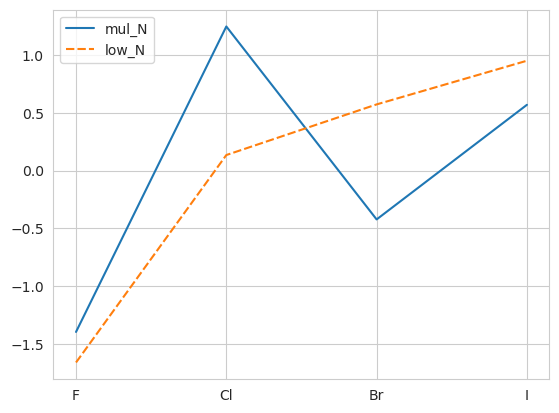

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    # res[['mul_N', 'low_N', 'npa_N']]
    res[['mul_N', 'low_N']]
)

<Axes: >

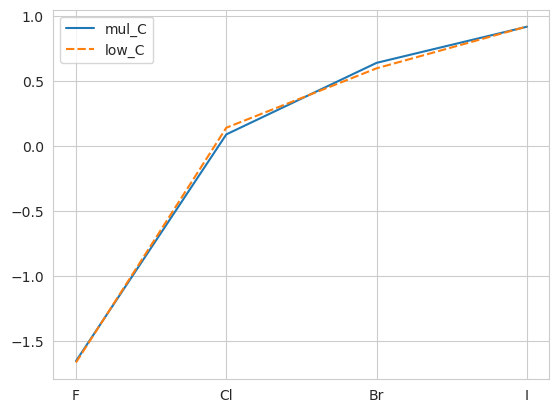

In [41]:
sns.lineplot(
    # res[['mul_C', 'low_C', 'npa_C']]
    res[['mul_C', 'low_C']]
)

In [ ]:
rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
rxn.Initialize()

amine, acid = rxn.GetReactants()
rxn.GetReactingAtoms()

In [ ]:
mol = load_smiles3D(Chem.MolToSmiles(amine), opt=True)
import logging
logging.getLogger().setLevel(logging.DEBUG)

In [ ]:
charges = np.hstack([charges, data.atomcharges['lowdin'][amine_raids]])

In [ ]:
homo = data.moenergies[0][data.homos[0]]
lumo = data.moenergies[0][data.homos[0] + 1]
homo, lumo

In [ ]:
dir(data)

In [ ]:
for ridx, reacting in enumerate(rxn.GetReactingAtoms()):
    reactant = rxn.GetReactantTemplate(ridx)
    print(Chem.MolToSmiles(reactant))
    for raidx in reacting:
        atom = reactant.GetAtomWithIdx(raidx)
        mapnum = atom.GetAtomMapNum()
        print('Mapped reacting atom:', atom.GetSymbol(), mapnum)
        # print(Chem.MolToSmiles(reactant))